# DataKind Red Cross Project Phase 2
## Home Fire Risk Data Model
10/28/2019
Tasks:
5. <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

# Data Import and Cleaning

## NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [2]:
nfirs_path = '../data/raw/NFIRS_2009_2016_Combined_Census_Tract.csv'

cols_to_use = ['state','fdid','city','zip5','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Fix the tot_loss column which had incorrect data for 2015. Since tot_loss = prop_loss + cont_loss, it was easy enough to recalculate those values
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

In [4]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [5]:
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

In [6]:
nfirs.sample(5)

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire,had_inj,had_death,10k_loss
902269,NY,34025,Liverpool,13088,2012-08-23,NaN,NaN,0.0,0.0,0.0,36067013701.0,not_sev_fire,no_inj,no_death,no_10k_loss
1272234,IL,CS563,LYNWD,60411,2014-01-26,NaN,NaN,0.0,0.0,0.0,17031828506.0,not_sev_fire,no_inj,no_death,no_10k_loss
1055309,MA,09262,SAUGUS,1906,2013-01-11,NaN,NaN,0.0,0.0,0.0,25009208102.0,not_sev_fire,no_inj,no_death,no_10k_loss
1777060,LA,9060,SHREVEPORT,71108,2016-05-04,NaN,NaN,0.0,0.0,0.0,22017022400.0,not_sev_fire,no_inj,no_death,no_10k_loss
997427,CT,2031,BLOOMFIELD,6002,2013-07-22,NaN,NaN,0.0,0.0,0.0,9003471100.0,not_sev_fire,no_inj,no_death,no_10k_loss


## Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [7]:
nfirs['GEOID'].str.len().value_counts()

13.0    1442479
12.0     196432
Name: GEOID, dtype: int64

In [8]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2]
                  .str.zfill(11))

In [9]:
nfirs.head()

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire,had_inj,had_death,10k_loss
0,AK,11100,JUNEAU,99801,2009-01-03,0.0,0.0,20000.0,5000.0,25000.0,02110000500,sev_fire,no_inj,no_death,had_10k_loss
1,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,0.0,0.0,0.0,02110000600,not_sev_fire,no_inj,no_death,no_10k_loss
2,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,20000.0,5000.0,25000.0,02110000100,sev_fire,no_inj,no_death,had_10k_loss
3,AK,11100,JUNEAU,99801,2009-01-13,0.0,0.0,200.0,20.0,220.0,02110000400,not_sev_fire,no_inj,no_death,no_10k_loss
4,AK,11100,JUNEAU,99801,2009-01-21,0.0,0.0,35000.0,5000.0,40000.0,02110000400,sev_fire,no_inj,no_death,had_10k_loss


In [10]:
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year

## SVI Data

In [11]:
svi2016_path = '../data/raw/SVI2016_US.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)

In [12]:
svi2016.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.644448,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,335.0
1,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.929908,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0
2,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0


## Aggregate nfirs by county & calculate per-capita rates

- Task 1: <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 3: <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.

In [13]:
# add the state+county unique identifier column to nfirs
nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_counties = pd.crosstab(nfirs['STCNTY'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_counties[(year,'tot_fires')] = nfirs_counties[(year,'not_sev_fire')] + nfirs_counties[(year,'sev_fire')]

# Sort the columns
nfirs_counties = nfirs_counties[sorted(nfirs_counties.columns)]

# aggregate svi data by county
svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_counties_rates = nfirs_svi_counties[['E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_counties_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_counties[(year,'tot_fires')] / nfirs_svi_counties['E_TOTPOP']
    nfirs_svi_counties_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_counties[(year,'sev_fire')] / nfirs_svi_counties['E_TOTPOP']

# Add the county and state columns to the dataset
nfirs_svi_counties_rates = nfirs_svi_counties_rates.merge(svi2016[['COUNTY','ST_ABBR','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
nfirs_svi_counties_rates = nfirs_svi_counties_rates.set_index('STCNTY')

# create list of severe columns & total columns
sev_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].mean(axis=1)
nfirs_svi_counties_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].std(axis=1)
nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].mean(axis=1)
nfirs_svi_counties_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_counties_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_counties_rates = nfirs_svi_counties_rates[cols]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


# County Level Learning Models

In [14]:
years_sev_fires = [(year,'sev_fire') for year in range(2009,2017)]

nfirs_counties_sev = nfirs_counties[years_sev_fires]

nfirs_counties_sev.columns = range(2009,2017)

In [15]:
nfirs_counties_sev['total'] = nfirs_counties_sev.sum(axis=1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
nfirs_counties_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total
STCNTY,,,,,,,,,
01001,13,9,7,2,4,2,9,8,54
01003,16,15,20,13,10,25,17,15,131
01005,3,0,0,5,0,6,0,1,15
01007,1,1,1,1,0,0,0,2,6
01009,4,4,14,5,4,4,4,5,44


In [17]:
nfirs_counties_sev.describe().round(2)

,2009,2010,2011,2012,2013,2014,2015,2016,total
count,3013.00,3013.00,3013.00,3013.00,3013.00,3013.00,3013.00,3013.00,3013.00
mean,12.60,13.35,12.87,13.00,13.86,15.72,15.30,12.98,109.68
std,46.95,47.40,38.90,45.68,47.55,51.78,48.96,37.56,354.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,7.00
50%,3.00,3.00,3.00,3.00,3.00,4.00,4.00,4.00,29.00
75%,10.00,11.00,10.00,11.00,11.00,13.00,13.00,11.00,91.00
max,1741.00,1570.00,985.00,1574.00,1645.00,1749.00,1614.00,989.00,11458.00


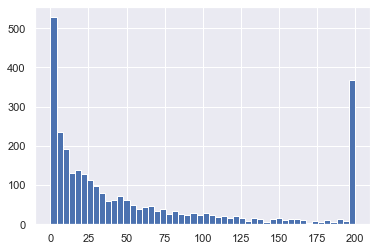

In [18]:
nfirs_counties_sev['total'].clip(0,200).hist(bins=50)

In [19]:
# nfirs_counties_sev = nfirs_counties_sev[nfirs_counties_sev['total'] >= 10]

## Correlation Coefficients

In [20]:
def plot_correlation_matrix_heat_map(df,label,qty_fields=10):
    df = pd.concat([df[label],df.drop(label,axis=1)],axis=1)
    correlation_matrix = df.corr()
    index = correlation_matrix.sort_values(label, ascending=False).index
    correlation_matrix = correlation_matrix[index].sort_values(label,ascending=False)

    fig,ax = plt.subplots()
    fig.set_size_inches((10,10))
    sns.heatmap(correlation_matrix.iloc[:qty_fields,:qty_fields],annot=True,fmt='.2f',ax=ax)
    return(fig,ax)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e0086976c8>)

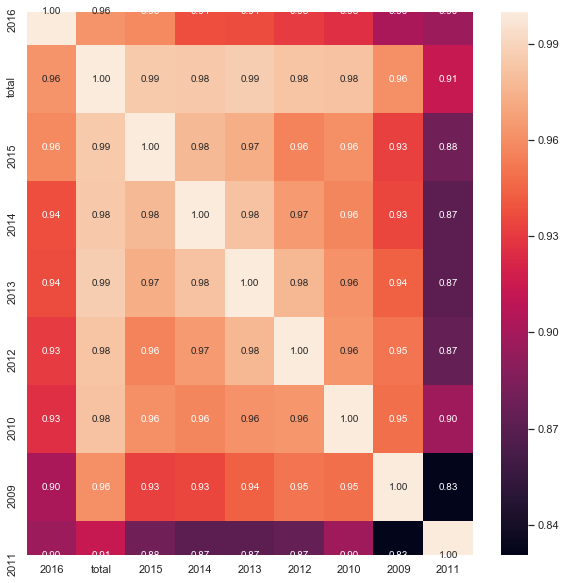

In [21]:
plot_correlation_matrix_heat_map(nfirs_counties_sev,2016)

## Linear Regression

Various models & features explored

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from yellowbrick.regressor import ResidualsPlot

In [23]:
features = list(range(2015,2008,-1))
label = 2016

scores = []

for i in range(1,len(features)):
    X_train, X_test, y_train, y_test = train_test_split(nfirs_counties_sev[features[:i]],nfirs_counties_sev[label],random_state=0)
    lr = LinearRegression()
    scores.append(cross_val_score(lr,X_train,y_train,cv=10))

scores_avg = [np.mean(score) for score in scores]

scores_avg

[0.890314090872115,
 0.887137947179766,
 0.8850983814252341,
 0.8846840947042708,
 0.8887742046172956,
 0.8934036401582244]

In [24]:
features = list(range(2015,2008,-1))
label = 2016

scores = []

for i in range(1,len(features)):
    X_train, X_test, y_train, y_test = train_test_split(nfirs_counties_sev[features[:i]],nfirs_counties_sev[label],random_state=0)
    lr = LinearRegression()
    scores.append(cross_val_score(lr,X_train,y_train,cv=10))

scores_avg = [np.mean(score) for score in scores]

scores_avg

[0.890314090872115,
 0.887137947179766,
 0.8850983814252341,
 0.8846840947042708,
 0.8887742046172956,
 0.8934036401582244]

In [25]:
nfirs_counties_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total
STCNTY,,,,,,,,,
01001,13,9,7,2,4,2,9,8,54
01003,16,15,20,13,10,25,17,15,131
01005,3,0,0,5,0,6,0,1,15
01007,1,1,1,1,0,0,0,2,6
01009,4,4,14,5,4,4,4,5,44


In [26]:
nfirs_counties_sev['avg_2009_2015'] = nfirs_counties_sev.iloc[:,0:7].mean(axis=1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
nfirs_counties_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total,avg_2009_2015
STCNTY,,,,,,,,,,
01001,13,9,7,2,4,2,9,8,54,6.571429
01003,16,15,20,13,10,25,17,15,131,16.571429
01005,3,0,0,5,0,6,0,1,15,2.000000
01007,1,1,1,1,0,0,0,2,6,0.571429
01009,4,4,14,5,4,4,4,5,44,5.571429


In [28]:
features = ['avg_2009_2015']
label = 2016

X_train,X_test,y_train,y_test = train_test_split(nfirs_counties_sev[features],nfirs_counties_sev[label],random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)

Training score:  0.9228889860529291
Test score:  0.8648840010906317
Root mean squared error:  13.767418237569387


In [29]:
features = [2015,'avg_2009_2015']
label = 2016

X_train,X_test,y_train,y_test = train_test_split(nfirs_counties_sev[features],nfirs_counties_sev[label],random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)

Training score:  0.9270411395964135
Test score:  0.9006824455301758
Root mean squared error:  11.803535931549144


In [30]:
features = list(range(2009,2016))
X_train,X_test,y_train,y_test = train_test_split(nfirs_counties_sev[features],nfirs_counties_sev[label],random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)

Training score:  0.9452684650444484
Test score:  0.8994274890217269
Root mean squared error:  11.87787537920217


In [31]:
nfirs_counties_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total,avg_2009_2015
STCNTY,,,,,,,,,,
01001,13,9,7,2,4,2,9,8,54,6.571429
01003,16,15,20,13,10,25,17,15,131,16.571429
01005,3,0,0,5,0,6,0,1,15,2.000000
01007,1,1,1,1,0,0,0,2,6,0.571429
01009,4,4,14,5,4,4,4,5,44,5.571429


In [32]:
for col in range(2010,2016):
    col_name = 'diff_{}_{}'.format(col-1,col)
    nfirs_counties_sev[col_name] = nfirs_counties_sev[col] - nfirs_counties_sev[col-1]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
nfirs_counties_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total,avg_2009_2015,diff_2009_2010,diff_2010_2011,diff_2011_2012,diff_2012_2013,diff_2013_2014,diff_2014_2015
STCNTY,,,,,,,,,,,,,,,,
01001,13,9,7,2,4,2,9,8,54,6.571429,-4,-2,-5,2,-2,7
01003,16,15,20,13,10,25,17,15,131,16.571429,-1,5,-7,-3,15,-8
01005,3,0,0,5,0,6,0,1,15,2.000000,-3,0,5,-5,6,-6
01007,1,1,1,1,0,0,0,2,6,0.571429,0,0,0,-1,0,0
01009,4,4,14,5,4,4,4,5,44,5.571429,0,10,-9,-1,0,0


In [34]:
features = [2015,'diff_2014_2015']

X_train,X_test,y_train,y_test = train_test_split(nfirs_counties_sev[features],nfirs_counties_sev[label],random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)

Training score:  0.9194483041005442
Test score:  0.9171932580983783
Root mean squared error:  10.777845816348458


In [35]:
features = [2015,'diff_2014_2015','diff_2013_2014']

X_train,X_test,y_train,y_test = train_test_split(nfirs_counties_sev[features],nfirs_counties_sev[label],random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)

Training score:  0.9195872503112807
Test score:  0.9181305871120811
Root mean squared error:  10.716672421832286


In [36]:
gs_lr.best_estimator_.coef_

array([ 0.7272298 ,  0.01510501, -0.061399  ])

In [37]:
features = [2015,2014,'diff_2014_2015','diff_2013_2014']

X_train,X_test,y_train,y_test = train_test_split(nfirs_counties_sev[features],nfirs_counties_sev[label],random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)
mae = mean_absolute_error(y_test,predictions)
print('Mean absolute error: ',mae)

Training score:  0.9195872503112806
Test score:  0.9181305871120811
Root mean squared error:  10.716672421832282
Mean absolute error:  4.589530852718249


In [38]:
nfirs_counties_sev[2016].describe()

count    3013.000000
mean       12.976767
std        37.557624
min         0.000000
25%         1.000000
50%         4.000000
75%        11.000000
max       989.000000
Name: 2016, dtype: float64

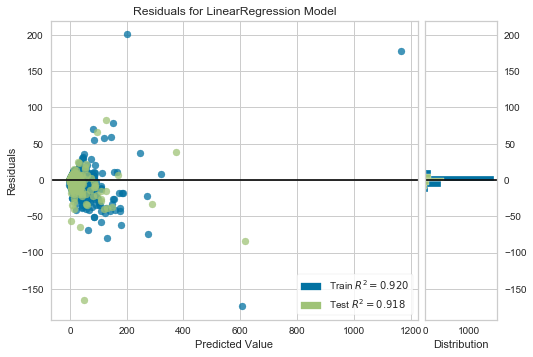

In [39]:
visualizer = ResidualsPlot(gs_lr.best_estimator_)

visualizer.fit(X_train, y_train)
visualizer.score(X_test,y_test)
visualizer.show()

So there are clearly a couple of huge outliers in the model. I'm guessing that a lot of those large outliers might be from counties which had a significant difference in reporting from one year to the next. I.e., if they had 0 reported fires in 2015, and then 200 in 2016, then obviously the model isn't going to correctly account for that. 

And perhaps even using 2016 as the label is an issue as well. The data quality is poor enough for the label itself, so it'll be difficult/impossible to tune a model that doesn't have an accurate set of labels to be tuned to.

## Linear models for counties with above 10 fires in dataset

In [40]:
# This will remove ~900 of the 3000 or so counties in the dataset
nfirs_top_counties_sev = nfirs_counties_sev[nfirs_counties_sev['total'] > 10]

In [41]:
nfirs_top_counties_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total,avg_2009_2015,diff_2009_2010,diff_2010_2011,diff_2011_2012,diff_2012_2013,diff_2013_2014,diff_2014_2015
STCNTY,,,,,,,,,,,,,,,,
01001,13,9,7,2,4,2,9,8,54,6.571429,-4,-2,-5,2,-2,7
01003,16,15,20,13,10,25,17,15,131,16.571429,-1,5,-7,-3,15,-8
01005,3,0,0,5,0,6,0,1,15,2.000000,-3,0,5,-5,6,-6
01009,4,4,14,5,4,4,4,5,44,5.571429,0,10,-9,-1,0,0
01013,9,6,2,7,1,6,6,5,42,5.285714,-3,-4,5,-6,5,0


In [42]:
features = [2015,2014,'diff_2014_2015','diff_2013_2014']

X_train,X_test,y_train,y_test = train_test_split(nfirs_top_counties_sev[features],nfirs_top_counties_sev[label],random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)
mae = mean_absolute_error(y_test,predictions)
print('Mean absolute error: ',mae)

Training score:  0.9043558299773773
Test score:  0.9210263510351512
Root mean squared error:  15.162099869154396
Mean absolute error:  6.424125964489578


# Census Tract Level Learning Models

## Aggregate nfirs by census tract and calculate per-capita rates

- Task 2: <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 4: <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population 

In [43]:
# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_tracts = pd.crosstab(nfirs['GEOID'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in nfirs['year'].unique():
    nfirs_tracts[(year,'tot_fires')] = nfirs_tracts[(year,'not_sev_fire')] + nfirs_tracts[(year,'sev_fire')]

# Sort the columns
nfirs_tracts = nfirs_tracts[sorted(nfirs_tracts.columns)]

# data already aggregated by census tract, so simply select the columns to merge
svi2016_tracts = svi2016[['FIPS','ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].set_index('FIPS')

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_tracts = svi2016_tracts.merge(nfirs_tracts,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_tracts_rates = nfirs_svi_tracts[['ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_tracts_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'tot_fires')] / nfirs_svi_tracts['E_TOTPOP']
    nfirs_svi_tracts_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'sev_fire')] / nfirs_svi_tracts['E_TOTPOP']

nfirs_svi_tracts_rates.index.name = 'GEOID'

# create list of severe columns & total columns
sev_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_tracts_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].std(axis=1)
nfirs_svi_tracts_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','LOCATION','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_tracts_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_tracts_rates = nfirs_svi_tracts_rates[cols]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [44]:
years_sev_fires = [(year,'sev_fire') for year in range(2009,2017)]

nfirs_tracts_sev = nfirs_tracts[years_sev_fires]

nfirs_tracts_sev.columns = range(2009,2017)

In [45]:
nfirs_tracts_sev['total'] = nfirs_tracts_sev.sum(axis=1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
nfirs_tracts_sev['avg_2009_2015'] = nfirs_tracts_sev.iloc[:,0:7].mean(axis=1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
for col in range(2010,2016):
    col_name = 'diff_{}_{}'.format(col-1,col)
    nfirs_tracts_sev[col_name] = nfirs_tracts_sev[col] - nfirs_tracts_sev[col-1]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
nfirs_tracts_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total,avg_2009_2015,diff_2009_2010,diff_2010_2011,diff_2011_2012,diff_2012_2013,diff_2013_2014,diff_2014_2015
GEOID,,,,,,,,,,,,,,,,
01001020100,2,2,0,0,0,0,1,2,7,0.714286,0,-2,0,0,0,1
01001020200,2,0,2,0,1,0,0,0,5,0.714286,-2,2,-2,1,-1,0
01001020300,2,1,1,1,0,1,2,2,10,1.142857,-1,0,0,-1,1,1
01001020400,1,0,2,0,0,0,2,0,5,0.714286,-1,2,-2,0,0,2
01001020500,1,3,1,0,0,0,3,3,11,1.142857,2,-2,-1,0,0,3


In [49]:
nfirs_tracts_sev[[2016,'total']].describe().round(1)

,2016,total
count,68129.0,68129.0
mean,0.6,4.9
std,1.2,6.1
min,0.0,0.0
25%,0.0,1.0
50%,0.0,3.0
75%,1.0,7.0
max,165.0,169.0


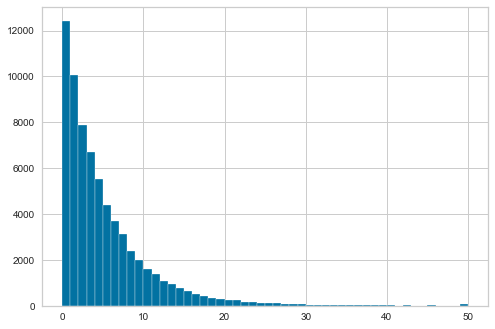

In [50]:
nfirs_tracts_sev['total'].clip(0,50).hist(bins=50)

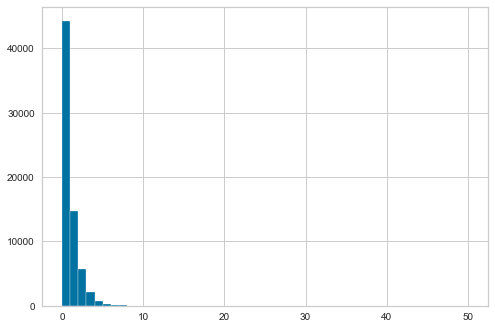

In [51]:
nfirs_tracts_sev[2016].clip(0,50).hist(bins=50)

In [52]:
nfirs_tracts_sev.shape

(68129, 16)

In [53]:
(nfirs_tracts_sev[2016]==0).sum()

44239

In [54]:
(nfirs_tracts_sev[2016] > 3).sum()

1376

In [55]:
(nfirs_tracts_sev[2016] > 5).sum()

260

In [56]:
(nfirs_tracts_sev['total'] > 5).sum()

21160

In [57]:
(nfirs_tracts_sev['total'] > 30).sum()

500

<b>So, the vast majority of census tracts have 0 fires in 2016. This analysis could probably just look at census tracts with above 5 fires or something like that, however the number of census tracts with above 5 severe fires is only 260. </b>

## Correlation Coefficients

### All tracts

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e00afeabc8>)

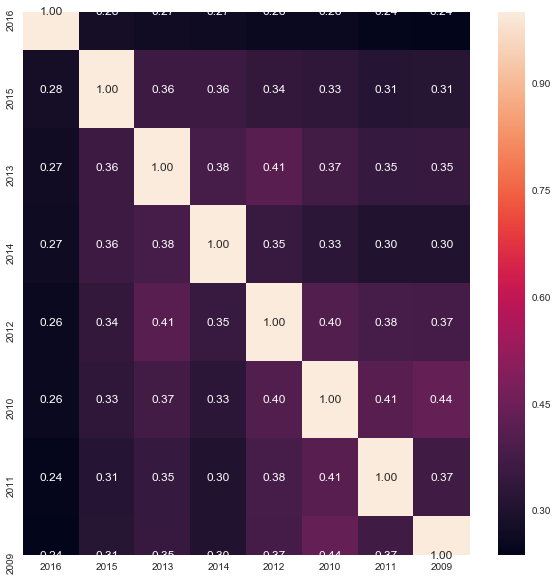

In [58]:
plot_correlation_matrix_heat_map(nfirs_tracts_sev[range(2009,2017)],2016)

In [59]:
nfirs_top_tracts_sev = nfirs_tracts_sev[nfirs_tracts_sev['total'] > 5]

### Tracts with at least 5 total fires

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e00b11b7c8>)

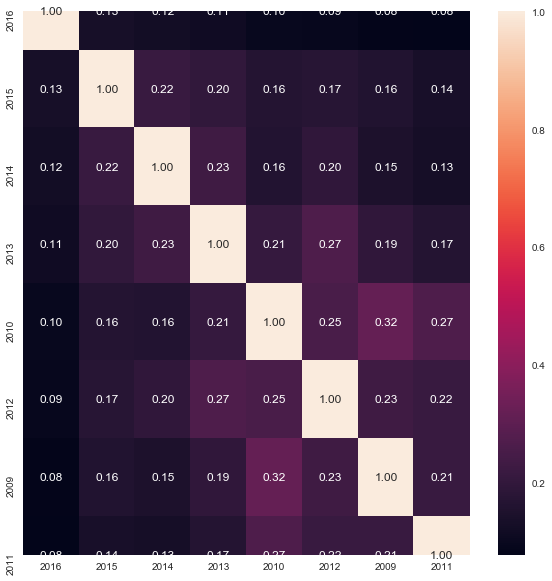

In [60]:
plot_correlation_matrix_heat_map(nfirs_top_tracts_sev[range(2009,2017)],2016)

Looking at only census tracts with above 5 total fires produces an even worse correlation matrix. Perhaps the number needs to be set way higher.

In [61]:
nfirs_top_tracts_sev = nfirs_tracts_sev[nfirs_tracts_sev['total'] > 30]

### Tracts with at least 30 total fires

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e0096ba408>)

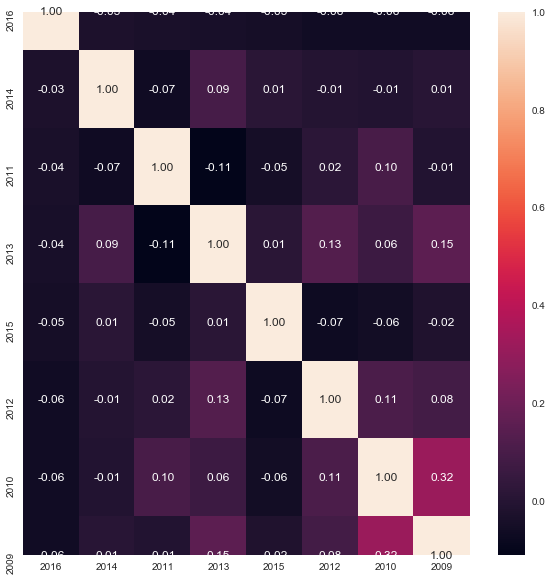

In [62]:
plot_correlation_matrix_heat_map(nfirs_top_tracts_sev[range(2009,2017)],2016)

In [63]:
nfirs_top_tracts_sev.head()

,2009,2010,2011,2012,2013,2014,2015,2016,total,avg_2009_2015,diff_2009_2010,diff_2010_2011,diff_2011_2012,diff_2012_2013,diff_2013_2014,diff_2014_2015
GEOID,,,,,,,,,,,,,,,,
01073003700,0,2,4,0,16,2,5,2,31,4.142857,2,2,-4,16,-14,3
01073005908,5,6,9,1,2,3,2,4,32,4.000000,1,3,-8,1,1,-1
01073011802,6,8,7,5,4,20,7,3,60,8.142857,2,-1,-2,-1,16,-13
01073011803,4,6,6,6,3,10,8,7,50,6.142857,2,0,0,-3,7,-2
02020000802,1,3,4,4,11,3,3,4,33,4.142857,2,1,0,7,-8,0


## Linear Regression

In [64]:
features = [2015,2014,'diff_2014_2015','diff_2013_2014']

X_train,X_test,y_train,y_test = train_test_split(nfirs_tracts_sev[features].drop('06033001200'),nfirs_tracts_sev[label].drop('06033001200'),random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)
mae = mean_absolute_error(y_test,predictions)
print('Mean absolute error: ',mae)

Training score:  0.1901032067631201
Test score:  0.1485680624879091
Root mean squared error:  0.9133839604808506
Mean absolute error:  0.6371099349046377


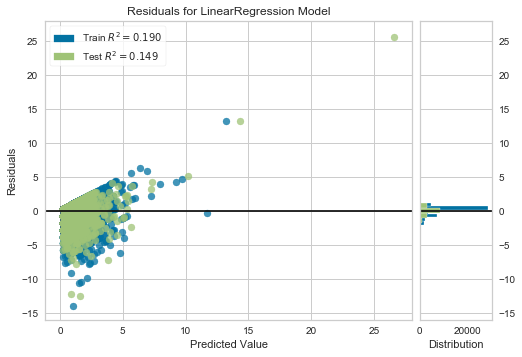

In [65]:
visualizer = ResidualsPlot(gs_lr.best_estimator_)

visualizer.fit(X_train, y_train)
visualizer.score(X_test,y_test)
visualizer.show()

## Linear Regression for tracts with at least 5 severe fires

In [66]:
# Only looking at the census tracts with at least 30 fires total
features = [2015,2014,'diff_2014_2015','diff_2013_2014']

# Dropped 06033001200 because it was the only clear outlier
X_train,X_test,y_train,y_test = train_test_split(nfirs_top_tracts_sev[features].drop('06033001200'),nfirs_top_tracts_sev[label].drop('06033001200'),random_state=1)

lr = LinearRegression()
params = {}
gs_lr = GridSearchCV(lr,params,cv=10)

gs_lr.fit(X_train,y_train)

print('Training score: ',gs_lr.score(X_train,y_train))
print('Test score: ',gs_lr.score(X_test,y_test))

predictions = gs_lr.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
print('Root mean squared error: ',rmse)
mae = mean_absolute_error(y_test,predictions)
print('Mean absolute error: ',mae)

Training score:  0.007408563343728192
Test score:  0.006891112309404313
Root mean squared error:  2.295106337248828
Mean absolute error:  1.7634766433552571


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


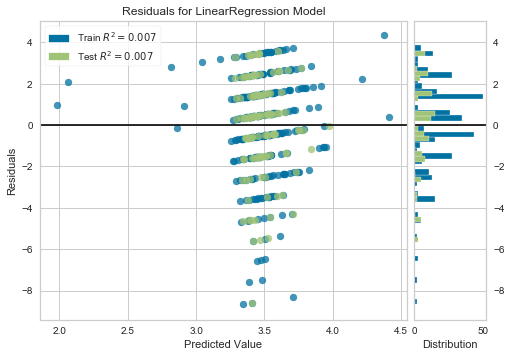

In [67]:
visualizer = ResidualsPlot(gs_lr.best_estimator_)

visualizer.fit(X_train, y_train)
visualizer.score(X_test,y_test)
visualizer.show()

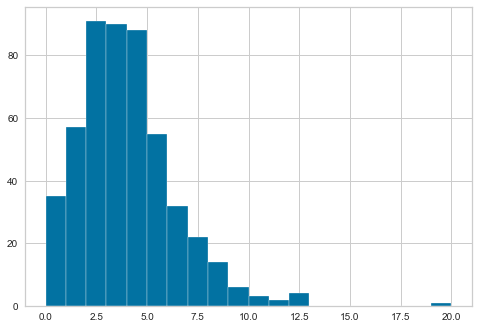

In [68]:
nfirs_top_tracts_sev[2016].clip(0,20).hist(bins=20)